In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from scipy.stats import norm

In [2]:
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (10, 4)

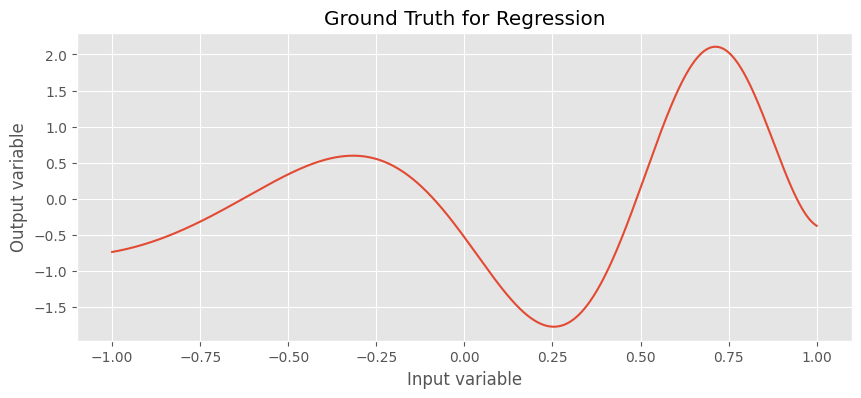

In [3]:
def unnormalised_ground_truth(x):
    """return the 'ground truth' output for a specific input location x"""
    return np.cos( 0.1*x**2 + 0.01*x - 1 ) + np.exp(0.1*x)

def normalised_ground_truth(xs):
    ys = unnormalised_ground_truth(5*xs + 5)
    m = ys.mean()
    s = ys.std()
    return (ys - m) / s

xs = np.linspace(-1, 1, 1000)
ys = normalised_ground_truth(xs)
plt.title("Ground Truth for Regression")
plt.plot(xs, ys)
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.show()

In [4]:
def plot_bnn_predictive_distribution(bnn_model, x_tr, y_tr, num_samps=1000):
    # Generate input data points for prediction
    xs = np.linspace(-1, 1, 500)
    
    # Get predictions from the BNN model
    preds = bnn_model(torch.FloatTensor(xs).unsqueeze(-1), num_samples=num_samps)[0].squeeze(-1).detach().numpy()
    
    # Calculate mean and standard deviation of predictions
    pred_mean = preds.mean(0)
    pred_std = preds.std(0)
    
    # Plot the predictive mean and 95% confidence interval
    plt.plot(xs, pred_mean, color='blue', label='Predictive mean')
    plt.fill_between(xs, pred_mean + 1.96*pred_std, pred_mean - 1.96*pred_std, color='blue', alpha=0.2, label='95% Confidence')

    # Plot the ground truth (assuming the function normalised_ground_truth is defined)
    ys = normalised_ground_truth(xs)
    plt.plot(xs, ys, color='red', label='Ground truth', zorder=900)
    
    # Plot the observed data points
    plt.scatter(x_tr, y_tr, color='black', label='Observed data', marker='2', zorder=1000)
    
    # Add title and legend
    plt.title("BNN Predictive Distribution vs Ground Truth", fontsize=18)
    plt.legend(fontsize=15, loc='lower center')
    
    # Set plot limits and customize ticks
    plt.xlim([-1, 1])
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    # Display the plot
    plt.show()

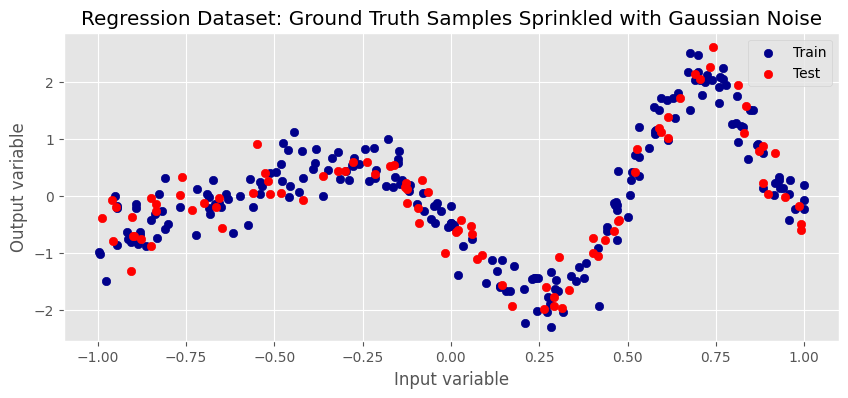

In [180]:
def gen_gaussian_noise(size=100, noise=0.5, test_size=0.3):
    xs = np.linspace(-1, 1, 1000)
    ys = normalised_ground_truth(xs)
    samp_ind = np.random.randint(0, 999, size)
    x_samps = xs[samp_ind]
    y_samps = ys[samp_ind] + np.random.normal(0, noise, size)
    return train_test_split(x_samps, y_samps, test_size=test_size)

np.random.seed(51)

x_tr, x_te, y_tr, y_te = gen_gaussian_noise(size=300, noise=0.3, test_size = 0.3)
plt.title("Regression Dataset: Ground Truth Samples Sprinkled with Gaussian Noise")
plt.scatter(x_tr, y_tr, label='Train', color='darkblue')
plt.scatter(x_te, y_te, label='Test', color='red')
plt.xlabel('Input variable')
plt.ylabel('Output variable')
plt.legend()
plt.show()

# transpose the pytorch tensor so it fits as expected later
x_tr = torch.FloatTensor(x_tr).unsqueeze(-1)
y_tr = torch.FloatTensor(y_tr).unsqueeze(-1)
x_te = torch.FloatTensor(x_te).unsqueeze(-1)
y_te = torch.FloatTensor(y_te).unsqueeze(-1)

In [ ]:
# alpha_values = np.arange(0.01, 1.0, 0.01)
# num_samples = 1000  # BNN posterior samples
# mseloss = nn.MSELoss()

# mcp_results_gaussian = {alpha: [] for alpha in alpha_values} #  Store MCP for each alpha
# mcp_results_t = {alpha: [] for alpha in alpha_values}  
# mcp_results_lap = {alpha: [] for alpha in alpha_values}
# mcp_results_mix = {alpha: [] for alpha in alpha_values}

# mse_gaussian = []
# mse_t = []
# mse_lap = []
# mse_mix = []

# noise = 0.3

# # large test set
# x_te_dense = torch.FloatTensor(np.linspace(-1, 1, 1000)).unsqueeze(-1)
# true_mean = normalised_ground_truth(x_te_dense)  # True function values

/var/folders/d5/bt4mpp9n3gngv4q0rms4ylwm0000gn/T/ipykernel_80060/94810905.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return np.cos( 0.1*x**2 + 0.01*x - 1 ) + np.exp(0.1*x)


In [9]:
class GaussianMeanFieldLayer(nn.Module):
    """Represents a mean-field Gaussian distribution over each layer of the network."""

    def __init__(self, input_dim, output_dim, init_var=0.05, prior_var=1):
        super(GaussianMeanFieldLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # Prior parameters p(theta)
        self.w_mu_p = torch.zeros(input_dim, output_dim)
        self.w_log_var_p = torch.ones(input_dim, output_dim) * torch.log(torch.tensor(prior_var))

        self.b_mu_p = torch.zeros(output_dim)
        self.b_log_var_p = torch.ones(output_dim) * torch.log(torch.tensor(prior_var))


        # Variational parameters q(theta)
        self.w_mu_q = nn.Parameter(torch.zeros(input_dim, output_dim), requires_grad=True)
        self.w_log_var_q = nn.Parameter(
            torch.ones(input_dim, output_dim) * torch.log(torch.tensor(init_var)), requires_grad=True
        )  
        self.b_mu_q = nn.Parameter(torch.zeros(output_dim), requires_grad=True)
        self.b_log_var_q = nn.Parameter(
            torch.ones(output_dim) * torch.log(torch.tensor(init_var)), requires_grad=True
        )

    # the priors do not change so could be stored as attributes, but
    # it feels cleaner to access them in the same way as the posteriors
    def p_w(self):
        """weight prior distribution"""
        return torch.distributions.Normal(self.w_mu_p, (0.5 * self.w_log_var_p).exp())

    def p_b(self):
        """bias prior distribution"""
        return torch.distributions.Normal(self.b_mu_p, (0.5 * self.b_log_var_p).exp())

    def q_w(self):
        """variational weight posterior"""
        return torch.distributions.Normal(self.w_mu_q, (0.5 * self.w_log_var_q).exp())

    def q_b(self):
        """variational bias posterior"""
        return torch.distributions.Normal(self.b_mu_q, (0.5 * self.b_log_var_q).exp())

    # def kl(self):
    #     weight_kl = torch.distributions.kl.kl_divergence(self.q_w(), self.p_w()).sum() 
    #     bias_kl = torch.distributions.kl.kl_divergence(self.q_b(), self.p_b()).sum()
    #     return weight_kl + bias_kl
    def kl(self, param_sample):
        weights = param_sample[0]
        biases = param_sample[1]
        weight_kl = self.q_w().log_prob(weights) - self.p_w().log_prob(weights)
        bias_kl = self.q_b().log_prob(biases) - self.p_b().log_prob(biases)
        return weight_kl.sum(dim=[1,2]).mean(0) + bias_kl.sum(dim=[1,2]).mean(0)



    def forward(self, x):
        """Propagates x through this layer by sampling weights from the posterior"""
        assert (len(x.shape) == 3), "x should be shape (num_samples, batch_size, input_dim)."
        assert x.shape[-1] == self.input_dim

        num_samples = x.shape[0]
        # rsample carries out reparameterisation trick for us   
        weights = self.q_w().rsample((num_samples,))  # (num_samples, input_dim, output_dim).
        # print('dim weights', weights.shape)

        biases = self.q_b().rsample((num_samples,)).unsqueeze(1)  # (num_samples, batch_size, output_dim)
        # print('dim biases', biases.shape)
        # print('dim x', x.shape)
        # print('dim x @ weights', (x @ weights).shape)
        
        # print('dim x @ weights + biases', (x @ weights + biases).shape)
        return x @ weights + biases, [weights, biases] # (num_samples, batch_size, output_dim).




class GaussianMeanFieldBNN(nn.Module):
    """Mean-field variational inference BNN."""

    def __init__(
        self,
        input_dim,
        hidden_dims,
        output_dim,
        activation = nn.ELU(),
        noise_std = 1.0,
        prior_var = 1
    ):
        super(GaussianMeanFieldBNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.activation = activation
        self.log_noise_var = torch.log(torch.tensor(noise_std**2))
        
        self.network = nn.ModuleList()
        for i in range(len(hidden_dims) + 1):
            if i == 0:
                self.network.append(GaussianMeanFieldLayer(self.input_dim, self.hidden_dims[i], prior_var = prior_var))
                self.network.append(self.activation)
            elif i == len(hidden_dims):
                self.network.append(
                    GaussianMeanFieldLayer(self.hidden_dims[i - 1], self.output_dim, prior_var = prior_var)
                )
            else:
                self.network.append(
                    GaussianMeanFieldLayer(self.hidden_dims[i - 1], self.hidden_dims[i], prior_var = prior_var)
                )
                self.network.append(self.activation) 

    def forward(self, x, num_samples=1):
        """Propagate the inputs through the network using num_samples weights.

        Args:
            x (torch.tensor): Inputs to the network.
            num_samples (int, optional): Number of samples to use. Defaults to 1.
        """
        assert len(x.shape) == 2, "x.shape must be (batch_size, input_dim)."
        param_samples = []
        # Expand dimensions of x to (num_samples, batch_size, input_dim).
        x = torch.unsqueeze(x, 0).repeat(num_samples, 1, 1)
        # Propagate x through network
        for layer in self.network:
            if isinstance(layer, GaussianMeanFieldLayer):
                x, param_sample = layer(x)
                param_samples.append(param_sample)
            else:
                x = layer(x)

        assert len(x.shape) == 3, "x.shape must be (num_samples, batch_size, output_dim)"
        assert x.shape[-1] == self.output_dim

        return x, param_samples

    def ll(self, y_obs, y_pred, num_samples=1):
        """Computes the log likelihood of the outputs of self.forward(x)"""
        l = torch.distributions.normal.Normal(y_pred, torch.sqrt(torch.exp(self.log_noise_var)))
        
        # take mean over num_samples dim, sum over batch_size dim
        # note that after taking mean, batch_size becomes dim 0
        return l.log_prob(y_obs.unsqueeze(0).repeat(num_samples, 1, 1)).mean(0).sum(0).squeeze()

    def kl(self,param_samples):
        """Computes the KL divergence between the approximate posterior and the prior for the network."""
        return sum([layer.kl(param_samples[i//2]) for i, layer in enumerate(self.network) if isinstance(layer, GaussianMeanFieldLayer)])


    # def loss(self, x, y, num_samples=1):
    #     """Computes the ELBO and returns its negative"""

    #     y_pred = self.forward(x, num_samples=num_samples)
        
    #     exp_ll = self.ll(y, y_pred, num_samples=num_samples)
    #     kl = self.kl()

    #     return kl - exp_ll, exp_ll, kl
    
    def loss(self, x, y, num_samples=1):
        """Computes the ELBO and returns its negative"""

        y_pred, param_samples = self.forward(x, num_samples=num_samples)
        
        exp_ll = self.ll(y, y_pred, num_samples=num_samples)
        kl = self.kl(param_samples)

        return kl - exp_ll, exp_ll, kl


In [10]:
class T_MeanFieldLayer(nn.Module):
    """Represents a mean-field Student's t-distribution over each layer of the network."""

    def __init__(self, input_dim, output_dim, df, prior_var=1,init_var=0.05):
        super(T_MeanFieldLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.df = df
        self.prior_scale = np.sqrt(((df-2)/df * prior_var))
        
        # Prior parameters p(theta)
        self.w_loc_p = torch.zeros(input_dim, output_dim)
        self.w_log_scale_p = torch.ones(input_dim, output_dim) * torch.log(torch.tensor(self.prior_scale))

        self.b_loc_p = torch.zeros(output_dim)
        self.b_log_scale_p = torch.ones(output_dim) * torch.log(torch.tensor(self.prior_scale))

        # Variational parameters q(theta)
        self.w_loc_q = nn.Parameter(torch.zeros(input_dim, output_dim), requires_grad=True)
        self.w_log_scale_q = nn.Parameter(
            torch.ones(input_dim, output_dim) * 0.5 * (torch.log(torch.tensor(init_var))), requires_grad=True)#torch.log(torch.tensor(self.prior_scale/2)), requires_grad=True
        # )  
        self.b_loc_q = nn.Parameter(torch.zeros(output_dim), requires_grad=True)
        self.b_log_scale_q = nn.Parameter(
            torch.ones(output_dim) * 0.5 * (torch.log(torch.tensor(init_var))), requires_grad=True)#torch.log(torch.tensor(self.prior_scale/2)), requires_grad=True
        
    # the priors do not change so could be stored as attributes, but
    # it feels cleaner to access them in the same way as the posteriors
    def p_w(self):
        """weight prior distribution"""
        return torch.distributions.StudentT(self.df, self.w_loc_p, self.w_log_scale_p.exp())

    def p_b(self):
        """bias prior distribution"""
        return torch.distributions.StudentT(self.df, self.b_loc_p, self.b_log_scale_p.exp())

    def q_w(self):
        """variational weight posterior"""
        return torch.distributions.StudentT(self.df, self.w_loc_q, torch.exp(self.w_log_scale_q))

    def q_b(self):
        """variational bias posterior"""
        return torch.distributions.StudentT(self.df, self.b_loc_q, torch.exp(self.b_log_scale_q))
    
    # def kl(self, num_samples = 1):
    #     weight_samples = self.q_w().rsample((num_samples,))  # rsample allows for gradient propagation
    #     bias_samples = self.q_b().rsample((num_samples,))

    #     log_q_w = self.q_w().log_prob(weight_samples)  
    #     log_p_w = self.p_w().log_prob(weight_samples)

    #     log_q_b = self.q_b().log_prob(bias_samples)
    #     log_p_b = self.p_b().log_prob(bias_samples)

    #     weight_kl = (log_q_w - log_p_w).mean()  # Average over samples
    #     bias_kl = (log_q_b - log_p_b).mean()
    #     return weight_kl + bias_kl

    def kl(self, param_sample):
        weights = param_sample[0]
        biases = param_sample[1]
        weight_kl = self.q_w().log_prob(weights) - self.p_w().log_prob(weights)
        bias_kl = self.q_b().log_prob(biases) - self.p_b().log_prob(biases)
        return weight_kl.sum(dim=[1,2]).mean(0) + bias_kl.sum(dim=[1,2]).mean(0)

    

    def forward(self, x):
        """Propagates x through this layer by sampling weights from the posterior"""
        assert (len(x.shape) == 3), "x should be shape (num_samples, batch_size, input_dim)."
        assert x.shape[-1] == self.input_dim

        num_samples = x.shape[0]
        # rsample carries out reparameterisation trick for us   
        weights = self.q_w().rsample((num_samples,))  # (num_samples, input_dim, output_dim).

        biases = self.q_b().rsample((num_samples,)).unsqueeze(1)  # (num_samples, batch_size, output_dim)
        # print(biases.shape)
        return x @ weights + biases, [weights, biases] # (num_samples, batch_size, output_dim).




class T_MeanFieldBNN(nn.Module):
    """Mean-field variational inference BNN."""

    def __init__(
        self,
        input_dim,
        hidden_dims,
        output_dim,
        df,
        activation = nn.ELU(),
        noise_std = 1.0,
        prior_var = 1
    ):
        super(T_MeanFieldBNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.activation = activation
        self.log_noise_var = torch.log(torch.tensor(noise_std**2))
        
        self.network = nn.ModuleList()
        for i in range(len(hidden_dims) + 1):
            if i == 0:
                self.network.append(T_MeanFieldLayer(self.input_dim, self.hidden_dims[i], df=df, prior_var = prior_var))
                self.network.append(self.activation)
            elif i == len(hidden_dims):
                self.network.append(
                    T_MeanFieldLayer(self.hidden_dims[i - 1], self.output_dim, df=df, prior_var = prior_var)
                )
            else:
                self.network.append(
                    T_MeanFieldLayer(self.hidden_dims[i - 1], self.hidden_dims[i], df=df, prior_var = prior_var)
                )
                self.network.append(self.activation) 

    def forward(self, x, num_samples=1):
        """Propagate the inputs through the network using num_samples weights.

        Args:
            x (torch.tensor): Inputs to the network.
            num_samples (int, optional): Number of samples to use. Defaults to 1.
        """
        assert len(x.shape) == 2, "x.shape must be (batch_size, input_dim)."
        param_samples = []
        # Expand dimensions of x to (num_samples, batch_size, input_dim).
        x = torch.unsqueeze(x, 0).repeat(num_samples, 1, 1)
        # Propagate x through network

        for layer in self.network:
            if isinstance(layer, T_MeanFieldLayer):
                x, param_sample = layer(x)
                param_samples.append(param_sample)
            else:
                x = layer(x)

        assert len(x.shape) == 3, "x.shape must be (num_samples, batch_size, output_dim)"
        assert x.shape[-1] == self.output_dim

        return x, param_samples

    def ll(self, y_obs, y_pred, num_samples=1):
        """Computes the log likelihood of the outputs of self.forward(x)"""
        l = torch.distributions.normal.Normal(y_pred, torch.sqrt(torch.exp(self.log_noise_var)))
        
        # take mean over num_samples dim, sum over batch_size dim
        # note that after taking mean, batch_size becomes dim 0
        return l.log_prob(y_obs.unsqueeze(0).repeat(num_samples, 1, 1)).mean(0).sum(0).squeeze()

    def kl(self,param_samples):
        """Computes the KL divergence between the approximate posterior and the prior for the network."""
        return sum([layer.kl(param_samples[i//2]) for i, layer in enumerate(self.network) if isinstance(layer, T_MeanFieldLayer)])

    def loss(self, x, y, num_samples=1):
        """Computes the ELBO and returns its negative"""

        y_pred, param_samples = self.forward(x, num_samples=num_samples)
        
        exp_ll = self.ll(y, y_pred, num_samples=num_samples)
        kl = self.kl(param_samples)

        return kl - exp_ll, exp_ll, kl

In [11]:
class Lap_MeanFieldLayer(nn.Module):
    """Represents a mean-field Laplace distribution over each layer of the network."""

    def __init__(self, input_dim, output_dim, prior_var=1,init_var=0.05
):
        super(Lap_MeanFieldLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.prior_scale = np.sqrt((prior_var/2))
        
        # Prior parameters p(theta)
        self.w_loc_p = torch.zeros(input_dim, output_dim)
        self.w_log_scale_p = torch.ones(input_dim, output_dim) * torch.log(torch.tensor(self.prior_scale))

        self.b_loc_p = torch.zeros(output_dim)
        self.b_log_scale_p = torch.ones(output_dim) * torch.log(torch.tensor(self.prior_scale))


        # Variational parameters q(theta)
        self.w_loc_q = nn.Parameter(torch.zeros(input_dim, output_dim), requires_grad=True)
        self.w_log_scale_q = nn.Parameter(
            torch.ones(input_dim, output_dim) * 0.5 * (torch.log(torch.tensor(init_var))), requires_grad=True)#torch.log(torch.tensor(self.prior_scale/2)), requires_grad=True
        # )  
        self.b_loc_q = nn.Parameter(torch.zeros(output_dim), requires_grad=True)
        self.b_log_scale_q = nn.Parameter(
            torch.ones(output_dim) * 0.5 * (torch.log(torch.tensor(init_var))), requires_grad=True)#torch.log(torch.tensor(self.prior_scale/2)), requires_grad=True
        

    # the priors do not change so could be stored as attributes, but
    # it feels cleaner to access them in the same way as the posteriors
    def p_w(self):
        """weight prior distribution"""
        return torch.distributions.Laplace(self.w_loc_p, self.w_log_scale_p.exp())#* np.sqrt(2 / self.output_dim))

    def p_b(self):
        """bias prior distribution"""
        return torch.distributions.Laplace(self.b_loc_p, self.b_log_scale_p.exp())

    def q_w(self):
        """variational weight posterior"""
        return torch.distributions.Laplace(self.w_loc_q, self.w_log_scale_q.exp())

    def q_b(self):
        """variational bias posterior"""
        return torch.distributions.Laplace(self.b_loc_q, self.b_log_scale_q.exp())
    

    def kl(self, param_sample):
        weights = param_sample[0]
        biases = param_sample[1]
        weight_kl = self.q_w().log_prob(weights) - self.p_w().log_prob(weights)
        bias_kl = self.q_b().log_prob(biases) - self.p_b().log_prob(biases)
        return weight_kl.sum(dim=[1,2]).mean(0) + bias_kl.sum(dim=[1,2]).mean(0)

    

    def forward(self, x):
        """Propagates x through this layer by sampling weights from the posterior"""
        assert (len(x.shape) == 3), "x should be shape (num_samples, batch_size, input_dim)."
        assert x.shape[-1] == self.input_dim

        num_samples = x.shape[0]
        # rsample carries out reparameterisation trick for us   
        weights = self.q_w().rsample((num_samples,))  # (num_samples, input_dim, output_dim).
        biases = self.q_b().rsample((num_samples,)).unsqueeze(1)  # (num_samples, batch_size, output_dim)
    
        # print(biases.shape)
        return x @ weights + biases, [weights, biases] # (num_samples, batch_size, output_dim).




class Lap_MeanFieldBNN(nn.Module):
    """Mean-field variational inference BNN."""

    def __init__(
        self,
        input_dim,
        hidden_dims,
        output_dim,
        activation = nn.ELU(),
        noise_std = 1.0,
        prior_var = 1
    ):
        super(Lap_MeanFieldBNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.activation = activation
        self.log_noise_var = torch.log(torch.tensor(noise_std**2))
        
        self.network = nn.ModuleList()
        for i in range(len(hidden_dims) + 1):
            if i == 0:
                self.network.append(Lap_MeanFieldLayer(self.input_dim, self.hidden_dims[i], prior_var = prior_var))
                self.network.append(self.activation)
            elif i == len(hidden_dims):
                self.network.append(
                    Lap_MeanFieldLayer(self.hidden_dims[i - 1], self.output_dim, prior_var = prior_var)
                )
            else:
                self.network.append(
                    Lap_MeanFieldLayer(self.hidden_dims[i - 1], self.hidden_dims[i], prior_var = prior_var)
                )
                self.network.append(self.activation) 

    def forward(self, x, num_samples=1):
        """Propagate the inputs through the network using num_samples weights.

        Args:
            x (torch.tensor): Inputs to the network.
            num_samples (int, optional): Number of samples to use. Defaults to 1.
        """
        assert len(x.shape) == 2, "x.shape must be (batch_size, input_dim)."
        param_samples = []
        # Expand dimensions of x to (num_samples, batch_size, input_dim).
        x = torch.unsqueeze(x, 0).repeat(num_samples, 1, 1)
        # Propagate x through network
        for layer in self.network:
            if isinstance(layer, Lap_MeanFieldLayer):
                x, param_sample = layer(x)
                param_samples.append(param_sample)
            else:
                x = layer(x)

        assert len(x.shape) == 3, "x.shape must be (num_samples, batch_size, output_dim)"
        assert x.shape[-1] == self.output_dim

        return x, param_samples

    def ll(self, y_obs, y_pred, num_samples=1):
        """Computes the log likelihood of the outputs of self.forward(x)"""
        l = torch.distributions.normal.Normal(y_pred, torch.sqrt(torch.exp(self.log_noise_var)))
        
        # take mean over num_samples dim, sum over batch_size dim
        # note that after taking mean, batch_size becomes dim 0
        return l.log_prob(y_obs.unsqueeze(0).repeat(num_samples, 1, 1)).mean(0).sum(0).squeeze()

    def kl(self,param_samples):
        """Computes the KL divergence between the approximate posterior and the prior for the network."""
        return sum([layer.kl(param_samples[i//2]) for i, layer in enumerate(self.network) if isinstance(layer, Lap_MeanFieldLayer)])

    def loss(self, x, y, num_samples=1):
        """Computes the ELBO and returns its negative"""

        y_pred, param_samples = self.forward(x, num_samples=num_samples)
        
        exp_ll = self.ll(y, y_pred, num_samples=num_samples)
        kl = self.kl(param_samples)

        return kl - exp_ll, exp_ll, kl

In [12]:
class GaussianMixtureLayer(nn.Module):
    """Represents a mean-field Gaussian distribution over each layer of the network."""

    def __init__(self, input_dim, output_dim, init_var=0.4, prior_var=1, num_components=2):
        super(GaussianMixtureLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_components = num_components
        self.w_mix_logits = nn.Parameter(torch.randn(num_components))  # Mixing coefficients
        self.b_mix_logits = nn.Parameter(torch.randn(num_components))  # Mixing coefficients

        # Prior parameters p(theta)
        self.w_mu_p = torch.zeros(input_dim, output_dim)  # Means
        self.w_log_var_p = torch.ones(input_dim, output_dim) * torch.log(torch.tensor(prior_var))


        self.b_mu_p = torch.zeros(output_dim)
        self.b_log_var_p = torch.ones(output_dim) * torch.log(torch.tensor(prior_var))


        # Variational parameters q(theta)
        self.w_mu_q = nn.Parameter(torch.zeros(num_components,input_dim, output_dim), requires_grad=True)
        self.w_log_var_q = nn.Parameter(
            torch.ones(num_components,input_dim, output_dim) * torch.log(torch.tensor(init_var)), requires_grad=True
        )  
        self.b_mu_q = nn.Parameter(torch.zeros(num_components,output_dim), requires_grad=True)
        self.b_log_var_q = nn.Parameter(
            torch.ones(num_components,output_dim) * torch.log(torch.tensor(init_var)), requires_grad=True
        )

    # the priors do not change so could be stored as attributes, but
    # it feels cleaner to access them in the same way as the posteriors
    def p_w(self):
        """weight prior distribution"""
        return torch.distributions.Normal(self.w_mu_p, (0.5 * self.w_log_var_p).exp())

    def p_b(self):
        """bias prior distribution"""
        return torch.distributions.Normal(self.b_mu_p, (0.5 * self.b_log_var_p).exp())
    
    # def q_w(self):
    #     """Variational weight posterior (mixture of Gaussians)"""
    #     w_mu_q_reshaped = self.w_mu_q.view(self.num_components, -1)  
    #     w_log_var_q_reshaped = self.w_log_var_q.view(self.num_components, -1)
    #     mix = torch.distributions.Categorical(logits=self.w_mix_logits)  # Mixing distribution
    #     components = torch.distributions.Normal(loc=w_mu_q_reshaped,scale=(0.5 * w_log_var_q_reshaped).exp())
    #     components = torch.distributions.Independent(components, 1)  # Makes event_shape [input_dim*output_dim]
    #     return torch.distributions.MixtureSameFamily(mix, components)

    def q_w(self):
        """Variational weight posterior (mixture of Gaussians)"""
        # Reshape parameters
        w_mu_q_reshaped = self.w_mu_q.view(self.num_components, -1)  # Shape: [num_components, input_dim * output_dim]
        w_log_var_q_reshaped = self.w_log_var_q.view(self.num_components, -1)  # Shape: [num_components, input_dim * output_dim]
        
        # Mixing distribution (Categorical)
        mix = torch.distributions.Categorical(logits=self.w_mix_logits)
        
        # Component distributions (Normal)
        components = torch.distributions.Normal(
            loc=w_mu_q_reshaped,  # Shape: [num_components, input_dim * output_dim]
            scale=(0.5 * w_log_var_q_reshaped).exp()  # Shape: [num_components, input_dim * output_dim]
        )
        
        # Wrap with Independent to treat the last dimension as event shape
        components = torch.distributions.Independent(components, 1)  # Event shape: [input_dim * output_dim]
        
        # Mixture model
        mixture = torch.distributions.MixtureSameFamily(mix, components)
        
        # Add rsample method manually
        def rsample(sample_shape=torch.Size()):
            # Sample from the categorical distribution to select components
            component_samples = mix.sample(sample_shape)  # Shape: [sample_shape]
            
            # Sample from the selected components using the reparameterization trick
            eps = torch.randn(sample_shape + components.event_shape, device=w_mu_q_reshaped.device)  # Shape: [sample_shape, input_dim * output_dim]
            component_means = w_mu_q_reshaped[component_samples]  # Shape: [sample_shape, input_dim * output_dim]
            component_scales = (0.5 * w_log_var_q_reshaped[component_samples]).exp()  # Shape: [sample_shape, input_dim * output_dim]
            samples = component_means + eps * component_scales  # Reparameterized samples
            
            return samples
        
        # Attach rsample method to the mixture object
        mixture.rsample = rsample
        
        return mixture

    def q_b(self):
        """Variational bias posterior (mixture of Gaussians)"""
        # Reshape parameters
        b_mu_q_reshaped = self.b_mu_q.view(self.num_components, -1)  # Shape: [num_components, input_dim * output_dim]
        b_log_var_q_reshaped = self.b_log_var_q.view(self.num_components, -1)  # Shape: [num_components, input_dim * output_dim]
        
        # Mixing distribution (Categorical)
        mix = torch.distributions.Categorical(logits=self.b_mix_logits)
        
        # Component distributions (Normal)
        components = torch.distributions.Normal(
            loc=b_mu_q_reshaped,  # Shape: [num_components, input_dim * output_dim]
            scale=(0.5 * b_log_var_q_reshaped).exp()  # Shape: [num_components, input_dim * output_dim]
        )
        
        # Wrap with Independent to treat the last dimension as event shape
        components = torch.distributions.Independent(components, 1)  # Event shape: [input_dim * output_dim]
        
        # Mixture model
        mixture = torch.distributions.MixtureSameFamily(mix, components)
        
        # Add rsample method manually
        def rsample(sample_shape=torch.Size()):
            # Sample from the categorical distribution to select components
            component_samples = mix.sample(sample_shape)  # Shape: [sample_shape]
            
            # Sample from the selected components using the reparameterization trick
            eps = torch.randn(sample_shape + components.event_shape)  # Shape: [sample_shape, input_dim * output_dim]
            component_means = b_mu_q_reshaped[component_samples]  # Shape: [sample_shape, input_dim * output_dim]
            component_scales = (0.5 * b_log_var_q_reshaped[component_samples]).exp()  # Shape: [sample_shape, input_dim * output_dim]
            samples = component_means + eps * component_scales  # Reparameterized samples
            
            return samples
        
        # Attach rsample method to the mixture object
        mixture.rsample = rsample
        
        return mixture

    # def kl(self):
    #     weight_kl = torch.distributions.kl.kl_divergence(self.q_w(), self.p_w()).sum() 
    #     bias_kl = torch.distributions.kl.kl_divergence(self.q_b(), self.p_b()).sum()
    #     return weight_kl + bias_kl
    def kl(self, param_sample):
        weights = param_sample[0]
        biases = param_sample[1]

        p_log_prob_w = self.p_w().log_prob(weights)
        summed_log_probs_w = p_log_prob_w.sum(dim=[1,2])

        p_log_prob_b = self.p_b().log_prob(biases)
        summed_log_probs_b = p_log_prob_b.sum(dim=[1,2])

        weight_kl = self.q_w().log_prob(weights.view(weights.shape[0],-1)) - summed_log_probs_w
        bias_kl = self.q_b().log_prob(biases).sum(-1) - summed_log_probs_b
        
        return weight_kl.mean(0) + bias_kl.mean(0)

    def forward(self, x):
        """Propagates x through this layer by sampling weights from the posterior"""
        assert (len(x.shape) == 3), "x should be shape (num_samples, batch_size, input_dim)."
        assert x.shape[-1] == self.input_dim

        num_samples = x.shape[0]
        # rsample carries out reparameterisation trick for us   
        weights = self.q_w().rsample((num_samples,)).view(num_samples, self.input_dim, self.output_dim)  # (num_samples, input_dim, output_dim).
        # print('dim weights', weights.shape)

        biases = self.q_b().rsample((num_samples,)).unsqueeze(1)  # (num_samples, batch_size, output_dim)
        # print('dim biases', biases.shape)
        # print('dim x', x.shape)
        # print('dim x @ weights', (x @ weights).shape)
        
        # print('dim x @ weights + biases', (x @ weights + biases).shape)
        return x @ weights + biases, [weights, biases] # (num_samples, batch_size, output_dim).
#  self.input_dim,self.output_dim)



class BNNWithMixturePosterior(nn.Module):
    """Mean-field variational inference BNN."""

    def __init__(
        self,
        input_dim,
        hidden_dims,
        output_dim,
        activation = nn.ELU(),
        noise_std = 1.0,
        prior_var = 1,
        num_components=2
    ):
        super(BNNWithMixturePosterior, self).__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.activation = activation
        self.log_noise_var = torch.log(torch.tensor(noise_std**2))
        
        self.network = nn.ModuleList()
        for i in range(len(hidden_dims) + 1):
            if i == 0:
                self.network.append(GaussianMixtureLayer(self.input_dim, self.hidden_dims[i], prior_var = prior_var, num_components=num_components))
                self.network.append(self.activation)
            elif i == len(hidden_dims):
                self.network.append(
                    GaussianMixtureLayer(self.hidden_dims[i - 1], self.output_dim, prior_var = prior_var,num_components=num_components)
                )
            else:
                self.network.append(
                    GaussianMixtureLayer(self.hidden_dims[i - 1], self.hidden_dims[i], prior_var = prior_var,num_components=num_components)
                )
                self.network.append(self.activation) 

    def forward(self, x, num_samples=1):
        """Propagate the inputs through the network using num_samples weights.

        Args:
            x (torch.tensor): Inputs to the network.
            num_samples (int, optional): Number of samples to use. Defaults to 1.
        """
        assert len(x.shape) == 2, "x.shape must be (batch_size, input_dim)."
        param_samples = []
        # Expand dimensions of x to (num_samples, batch_size, input_dim).
        x = torch.unsqueeze(x, 0).repeat(num_samples, 1, 1)
        # Propagate x through network
        for layer in self.network:
            if isinstance(layer, GaussianMixtureLayer):
                x, param_sample = layer(x)
                param_samples.append(param_sample)
            else:
                x = layer(x)

        assert len(x.shape) == 3, "x.shape must be (num_samples, batch_size, output_dim)"
        assert x.shape[-1] == self.output_dim

        return x, param_samples

    def ll(self, y_obs, y_pred, num_samples=1):
        """Computes the log likelihood of the outputs of self.forward(x)"""
        l = torch.distributions.normal.Normal(y_pred, torch.sqrt(torch.exp(self.log_noise_var)))
        
        # take mean over num_samples dim, sum over batch_size dim
        # note that after taking mean, batch_size becomes dim 0
        return l.log_prob(y_obs.unsqueeze(0).repeat(num_samples, 1, 1)).mean(0).sum(0).squeeze()

    def kl(self,param_samples):
        """Computes the KL divergence between the approximate posterior and the prior for the network."""
        return sum([layer.kl(param_samples[i//2]) for i, layer in enumerate(self.network) if isinstance(layer, GaussianMixtureLayer)])

    
    def loss(self, x, y, num_samples=1):
        """Computes the ELBO and returns its negative"""
        y_pred, param_samples = self.forward(x, num_samples=num_samples)
        
        exp_ll = self.ll(y, y_pred, num_samples=num_samples)
        kl = self.kl(param_samples)

        return kl - exp_ll, exp_ll, kl


In [181]:
gaussian_bnn_model = GaussianMeanFieldBNN(1, [10, 10], 1, noise_std=0.3, prior_var = 0.4)
t_bnn_model = T_MeanFieldBNN(1, [10, 10], 1, df=5, noise_std=0.3, prior_var = 0.4)
lap_bnn_model = Lap_MeanFieldBNN(1, [10, 10], 1, noise_std=0.3, prior_var = 0.4) # these were all .4, i made them wider to see effect
mix_bnn_model = BNNWithMixturePosterior(1, [10,10],1, noise_std = 0.3, prior_var = 0.4)

g_opt = torch.optim.Adam(
    gaussian_bnn_model.parameters(),
    lr = 1e-1
)

t_opt = torch.optim.Adam(
    t_bnn_model.parameters(),
    lr = 1e-1
)

lap_opt = torch.optim.Adam(
    lap_bnn_model.parameters(),
    lr = 1e-1
)

mix_opt = torch.optim.Adam(
    mix_bnn_model.parameters(),
    lr = 1e-1
)

# ExponentialLR schedulers for each optimizer
gamma = 0.999  # You can adjust this value as needed

g_scheduler = torch.optim.lr_scheduler.ExponentialLR(g_opt, gamma=gamma)
t_scheduler = torch.optim.lr_scheduler.ExponentialLR(t_opt, gamma=gamma)
lap_scheduler = torch.optim.lr_scheduler.ExponentialLR(lap_opt, gamma=gamma)
mix_scheduler = torch.optim.lr_scheduler.ExponentialLR(mix_opt, gamma=gamma)

100%|██████████| 4000/4000 [00:14<00:00, 270.02it/s]


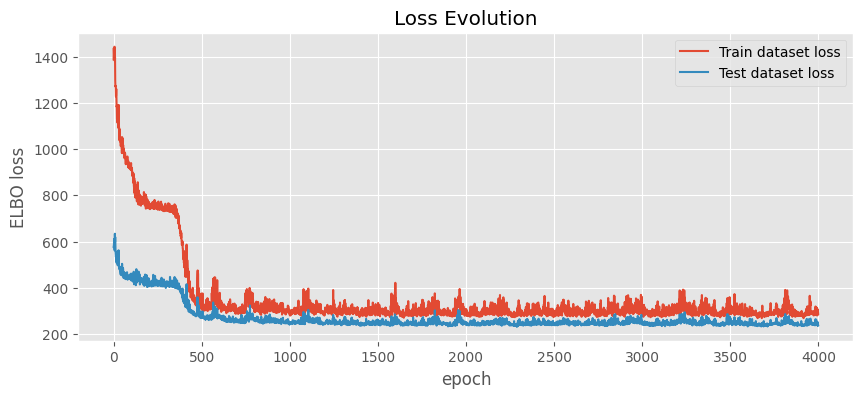

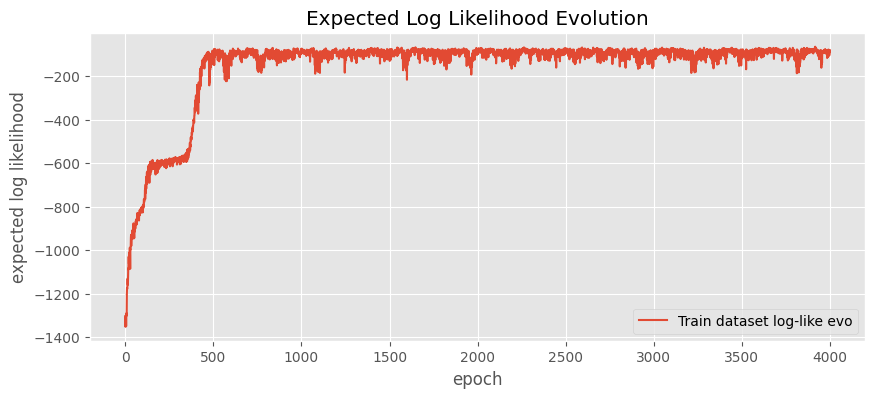

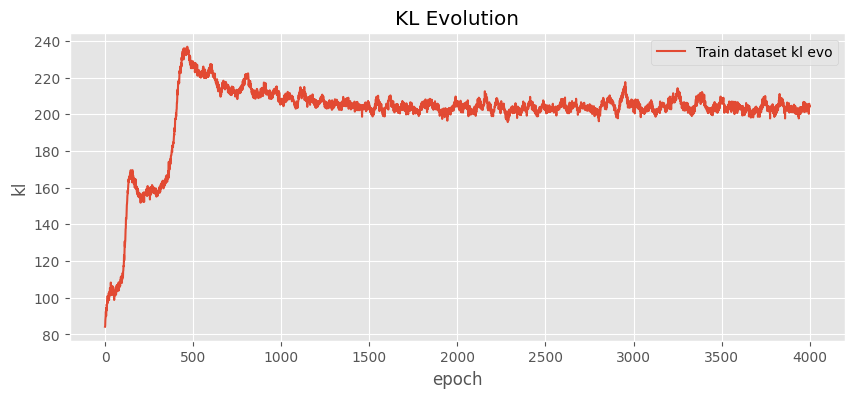

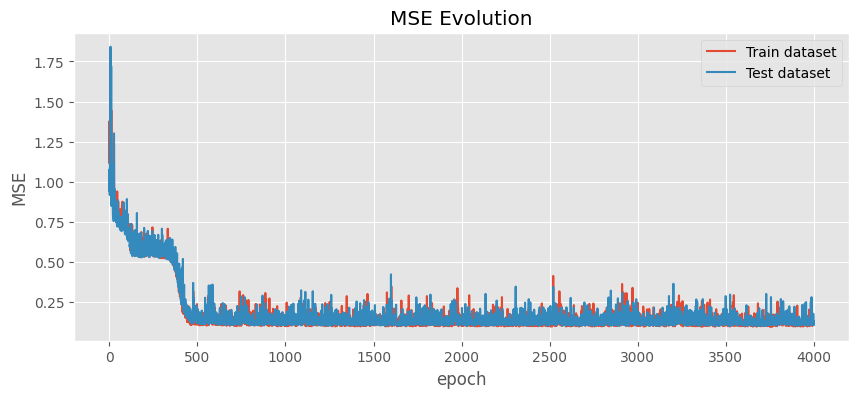

In [182]:
# Train Gaussian
tr_loss_evo = []
tr_ll_evo = []
tr_kl_evo = []
te_loss_evo = []
tr_mse_loss_evo = []
te_mse_loss_evo = []
aux_loss = nn.MSELoss()

epochs = 4000 


for epoch in tqdm(range(epochs)):  # epochs
    g_opt.zero_grad()

    l, ll, kl = gaussian_bnn_model.loss(x_tr, y_tr, num_samples = 20)
    tr_loss_evo.append(l.item())
    tr_ll_evo.append(ll.item())
    tr_kl_evo.append(kl.item())
    tr_mse_loss_evo.append(aux_loss(gaussian_bnn_model(x_tr)[0], y_tr.unsqueeze(0)).item())

    te_loss_evo.append(gaussian_bnn_model.loss(x_te, y_te,num_samples=20)[0].item())
    te_mse_loss_evo.append(aux_loss(gaussian_bnn_model(x_te)[0], y_te.unsqueeze(0)).item())

    l.backward()
    g_opt.step()


plt.rcParams["figure.figsize"] = (10, 4)

plt.plot(tr_loss_evo, label='Train dataset loss')
plt.plot(te_loss_evo, label='Test dataset loss')
plt.ylabel('ELBO loss')
plt.xlabel('epoch')
plt.legend()
plt.title('Loss Evolution')
plt.show()

plt.plot(tr_ll_evo, label='Train dataset log-like evo')
plt.ylabel('expected log likelihood')
plt.xlabel('epoch')
plt.legend()
plt.title('Expected Log Likelihood Evolution')
plt.show()

plt.plot(tr_kl_evo, label='Train dataset kl evo')
plt.ylabel('kl')
plt.xlabel('epoch')
plt.legend()
plt.title('KL Evolution')
plt.show()

plt.plot(tr_mse_loss_evo, label='Train dataset')
plt.plot(te_mse_loss_evo, label='Test dataset')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend()
plt.title('MSE Evolution')
plt.show()

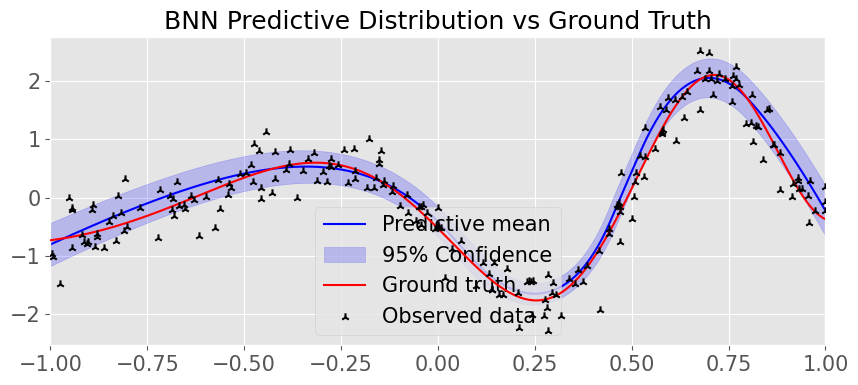

In [183]:
plot_bnn_predictive_distribution(gaussian_bnn_model, x_tr, y_tr)

In [184]:
## happy with the plot? capture it!
    # Compute PICP on a large test set
posterior_samples  = gaussian_bnn_model(x_te_dense, num_samples)[0].detach().numpy()  # Shape: (num_samples, 1000)

for alpha in alpha_values:

    lower_bounds = np.quantile(posterior_samples, alpha / 2, axis=0)
    upper_bounds = np.quantile(posterior_samples, 1 - alpha / 2, axis=0)


    # Compute coverage probabilities for gaussian noise
    coverage_probs = norm.cdf(upper_bounds, loc=true_mean, scale=noise) - \
                            norm.cdf(lower_bounds, loc=true_mean, scale=noise)
    


    # Store results
    mcp_results_gaussian[alpha].append(np.mean(coverage_probs))

## Get MSEs
mse_gaussian.append(mseloss(gaussian_bnn_model(x_te, num_samples)[0], y_te.unsqueeze(0)).item())


100%|██████████| 4000/4000 [00:22<00:00, 176.83it/s]


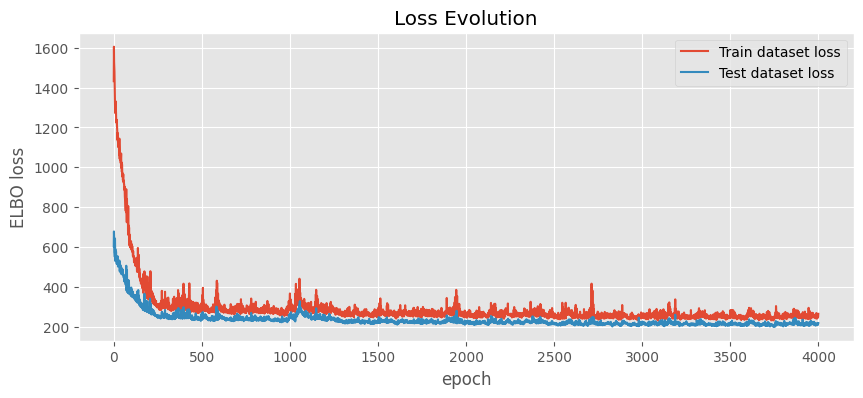

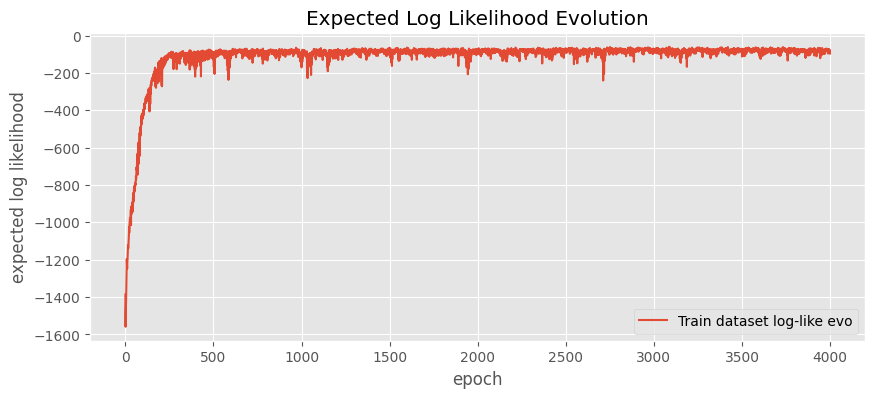

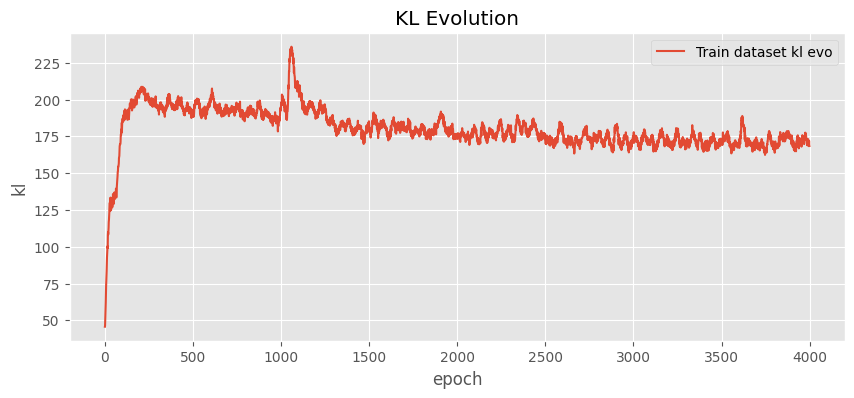

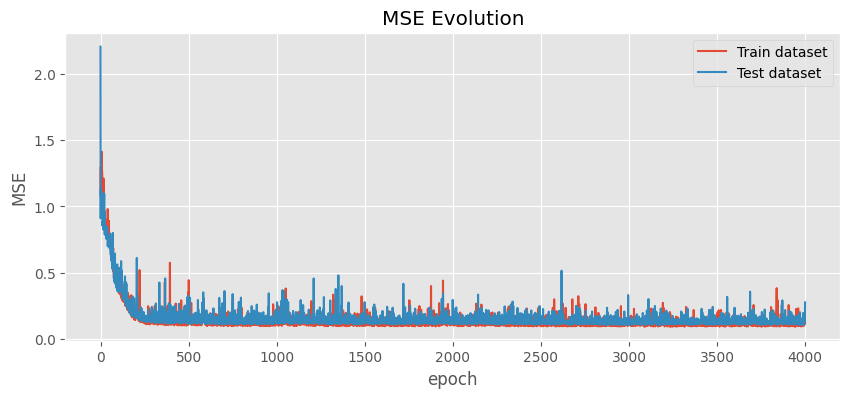

In [185]:
# Train T
tr_loss_evo = []
tr_ll_evo = []
tr_kl_evo = []
te_loss_evo = []
tr_mse_loss_evo = []
te_mse_loss_evo = []
aux_loss = nn.MSELoss()

epochs = 4000 


for epoch in tqdm(range(epochs)):  # epochs
    t_opt.zero_grad()

    l, ll, kl = t_bnn_model.loss(x_tr, y_tr, num_samples = 20)
    tr_loss_evo.append(l.item())
    tr_ll_evo.append(ll.item())
    tr_kl_evo.append(kl.item())
    tr_mse_loss_evo.append(aux_loss(t_bnn_model(x_tr)[0], y_tr.unsqueeze(0)).item())

    te_loss_evo.append(t_bnn_model.loss(x_te, y_te,num_samples=20)[0].item())
    te_mse_loss_evo.append(aux_loss(t_bnn_model(x_te)[0], y_te.unsqueeze(0)).item())

    l.backward()
    t_opt.step()


plt.rcParams["figure.figsize"] = (10, 4)

plt.plot(tr_loss_evo, label='Train dataset loss')
plt.plot(te_loss_evo, label='Test dataset loss')
plt.ylabel('ELBO loss')
plt.xlabel('epoch')
plt.legend()
plt.title('Loss Evolution')
plt.show()

plt.plot(tr_ll_evo, label='Train dataset log-like evo')
plt.ylabel('expected log likelihood')
plt.xlabel('epoch')
plt.legend()
plt.title('Expected Log Likelihood Evolution')
plt.show()

plt.plot(tr_kl_evo, label='Train dataset kl evo')
plt.ylabel('kl')
plt.xlabel('epoch')
plt.legend()
plt.title('KL Evolution')
plt.show()

plt.plot(tr_mse_loss_evo, label='Train dataset')
plt.plot(te_mse_loss_evo, label='Test dataset')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend()
plt.title('MSE Evolution')
plt.show()

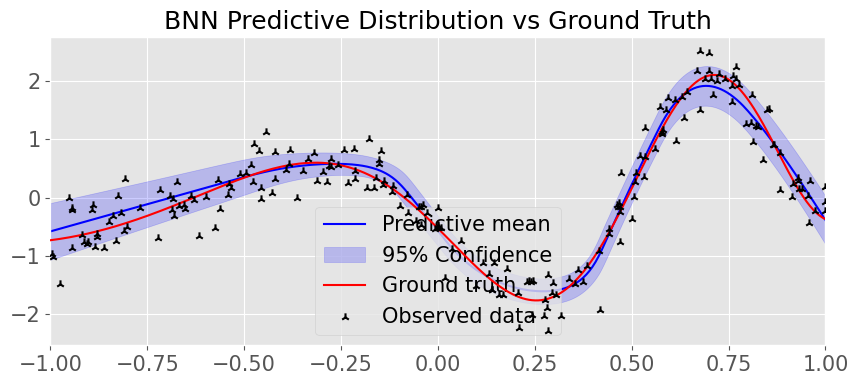

In [186]:
plot_bnn_predictive_distribution(t_bnn_model, x_tr, y_tr)

In [187]:
## happy with the plot? capture it!
    # Compute PICP on a large test set
posterior_samples  = t_bnn_model(x_te_dense, num_samples)[0].detach().numpy()  # Shape: (num_samples, 1000)

for alpha in alpha_values:

    lower_bounds = np.quantile(posterior_samples, alpha / 2, axis=0)
    upper_bounds = np.quantile(posterior_samples, 1 - alpha / 2, axis=0)


    # Compute coverage probabilities for gaussian noise
    coverage_probs = norm.cdf(upper_bounds, loc=true_mean, scale=noise) - \
                            norm.cdf(lower_bounds, loc=true_mean, scale=noise)
    


    # Store results
    mcp_results_t[alpha].append(np.mean(coverage_probs))

## Get MSEs
mse_t.append(mseloss(t_bnn_model(x_te, num_samples)[0], y_te.unsqueeze(0)).item())


100%|██████████| 200/200 [00:00<00:00, 246.44it/s]


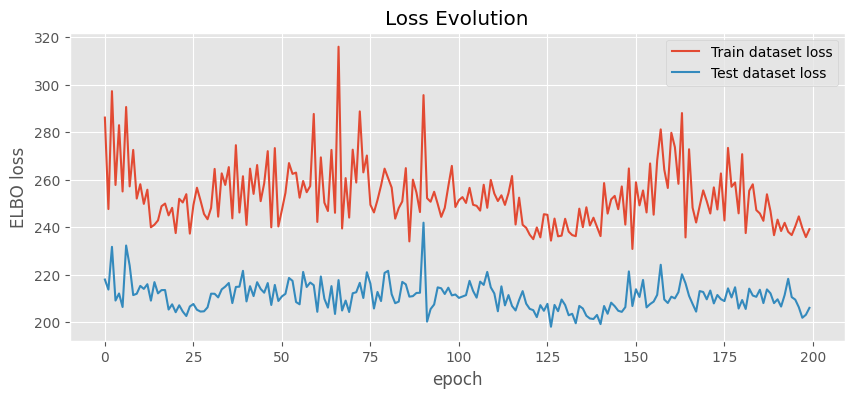

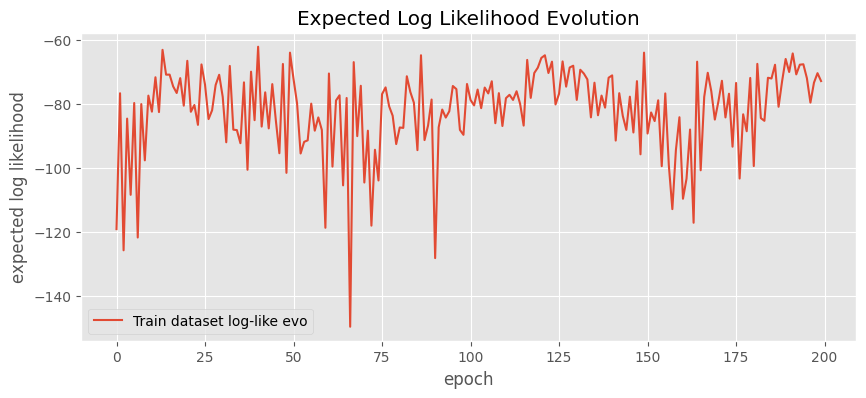

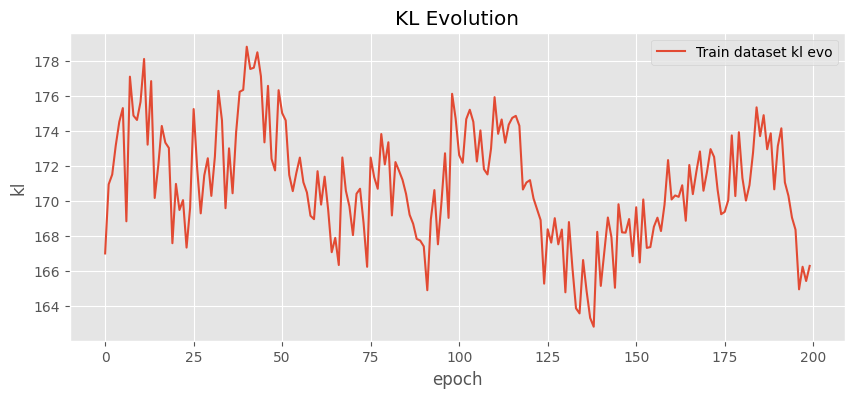

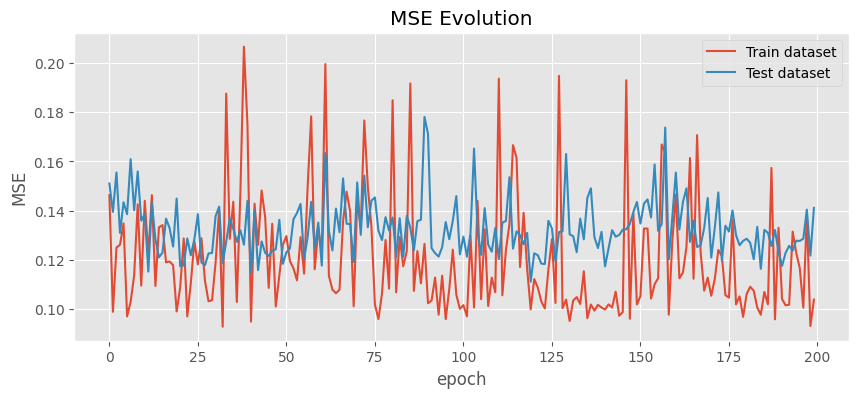

In [ ]:
# Train Laplace

tr_loss_evo = []
tr_ll_evo = []
tr_kl_evo = []
te_loss_evo = []
tr_mse_loss_evo = []
te_mse_loss_evo = []
aux_loss = nn.MSELoss()

epochs = 4000 


for epoch in tqdm(range(epochs)):  # epochs
    lap_opt.zero_grad()

    l, ll, kl = lap_bnn_model.loss(x_tr, y_tr, num_samples = 20)
    tr_loss_evo.append(l.item())
    tr_ll_evo.append(ll.item())
    tr_kl_evo.append(kl.item())
    tr_mse_loss_evo.append(aux_loss(lap_bnn_model(x_tr)[0], y_tr.unsqueeze(0)).item())

    te_loss_evo.append(lap_bnn_model.loss(x_te, y_te,num_samples=20)[0].item())
    te_mse_loss_evo.append(aux_loss(lap_bnn_model(x_te, num_samples=10)[0], y_te.unsqueeze(0)).item())

    l.backward()
    lap_opt.step()


plt.rcParams["figure.figsize"] = (10, 4)

plt.plot(tr_loss_evo, label='Train dataset loss')
plt.plot(te_loss_evo, label='Test dataset loss')
plt.ylabel('ELBO loss')
plt.xlabel('epoch')
plt.legend()
plt.title('Loss Evolution')
plt.show()

plt.plot(tr_ll_evo, label='Train dataset log-like evo')
plt.ylabel('expected log likelihood')
plt.xlabel('epoch')
plt.legend()
plt.title('Expected Log Likelihood Evolution')
plt.show()

plt.plot(tr_kl_evo, label='Train dataset kl evo')
plt.ylabel('kl')
plt.xlabel('epoch')
plt.legend()
plt.title('KL Evolution')
plt.show()

plt.plot(tr_mse_loss_evo, label='Train dataset')
plt.plot(te_mse_loss_evo, label='Test dataset')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend()
plt.title('MSE Evolution')
plt.show()

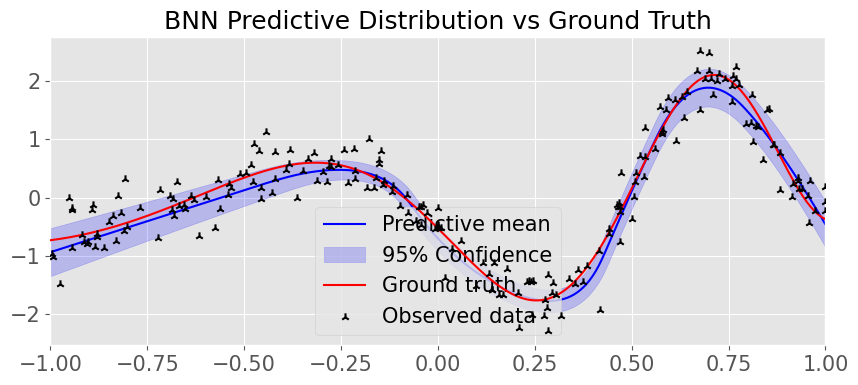

In [192]:
plot_bnn_predictive_distribution(lap_bnn_model, x_tr, y_tr)

In [193]:
## happy with the plot? capture it!
    # Compute PICP on a large test set
posterior_samples  = lap_bnn_model(x_te_dense, num_samples)[0].detach().numpy()  # Shape: (num_samples, 1000)

for alpha in alpha_values:

    lower_bounds = np.quantile(posterior_samples, alpha / 2, axis=0)
    upper_bounds = np.quantile(posterior_samples, 1 - alpha / 2, axis=0)


    # Compute coverage probabilities for gaussian noise
    coverage_probs = norm.cdf(upper_bounds, loc=true_mean, scale=noise) - \
                            norm.cdf(lower_bounds, loc=true_mean, scale=noise)
    


    # Store results
    mcp_results_lap[alpha].append(np.mean(coverage_probs))

## Get MSEs
mse_lap.append(mseloss(lap_bnn_model(x_te, num_samples)[0], y_te.unsqueeze(0)).item())


100%|██████████| 1000/1000 [00:06<00:00, 143.69it/s]


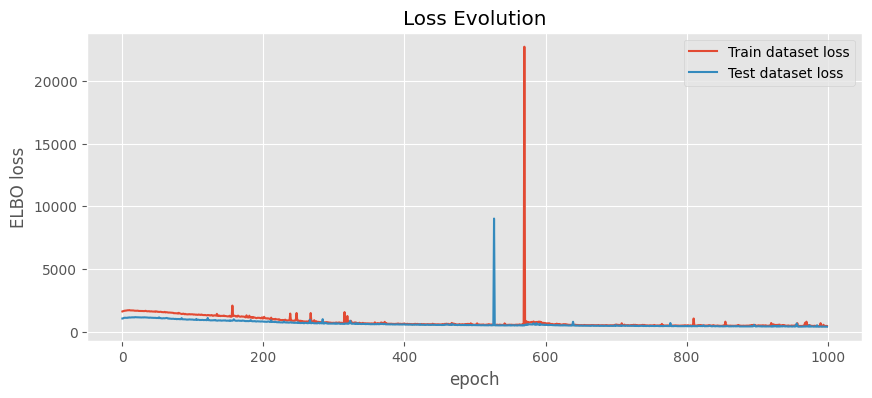

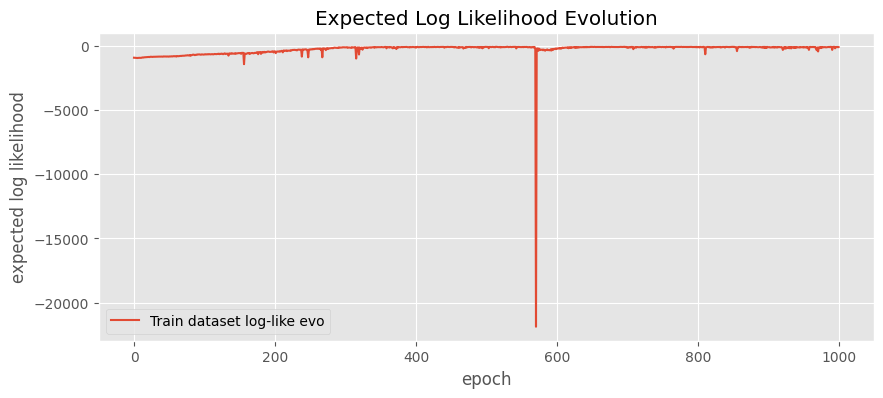

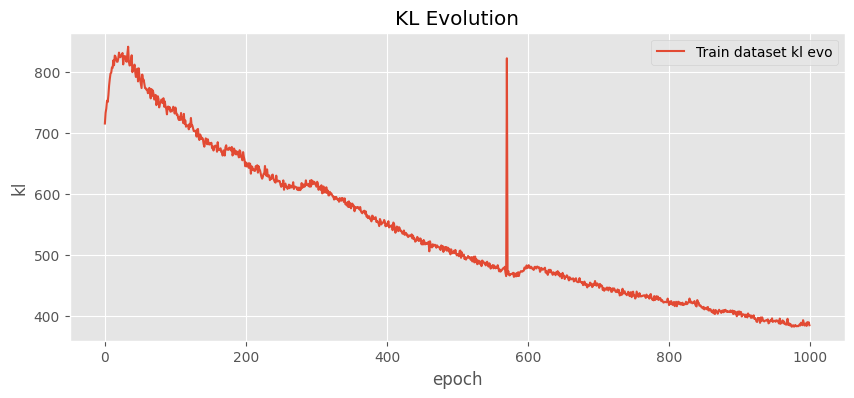

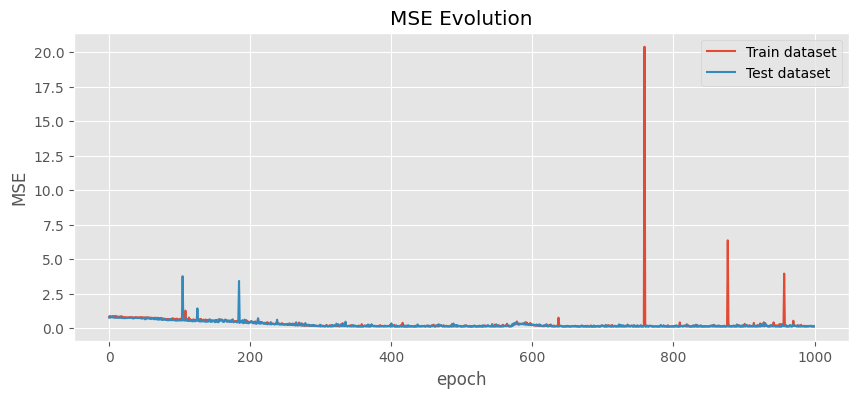

In [196]:
# Train Mix
tr_loss_evo = []
tr_ll_evo = []
tr_kl_evo = []
te_loss_evo = []
tr_mse_loss_evo = []
te_mse_loss_evo = []
aux_loss = nn.MSELoss()

epochs = 4000 


for epoch in tqdm(range(epochs)):  # epochs
    mix_opt.zero_grad()

    l, ll, kl = mix_bnn_model.loss(x_tr, y_tr, num_samples = 20)
    tr_loss_evo.append(l.item())
    tr_ll_evo.append(ll.item())
    tr_kl_evo.append(kl.item())
    tr_mse_loss_evo.append(aux_loss(mix_bnn_model(x_tr)[0], y_tr.unsqueeze(0)).item())

    te_loss_evo.append(mix_bnn_model.loss(x_te, y_te,num_samples=20)[0].item())
    te_mse_loss_evo.append(aux_loss(mix_bnn_model(x_te)[0], y_te.unsqueeze(0)).item())

    l.backward()
    mix_opt.step()


plt.rcParams["figure.figsize"] = (10, 4)

plt.plot(tr_loss_evo, label='Train dataset loss')
plt.plot(te_loss_evo, label='Test dataset loss')
plt.ylabel('ELBO loss')
plt.xlabel('epoch')
plt.legend()
plt.title('Loss Evolution')
plt.show()

plt.plot(tr_ll_evo, label='Train dataset log-like evo')
plt.ylabel('expected log likelihood')
plt.xlabel('epoch')
plt.legend()
plt.title('Expected Log Likelihood Evolution')
plt.show()

plt.plot(tr_kl_evo, label='Train dataset kl evo')
plt.ylabel('kl')
plt.xlabel('epoch')
plt.legend()
plt.title('KL Evolution')
plt.show()

plt.plot(tr_mse_loss_evo, label='Train dataset')
plt.plot(te_mse_loss_evo, label='Test dataset')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend()
plt.title('MSE Evolution')
plt.show()

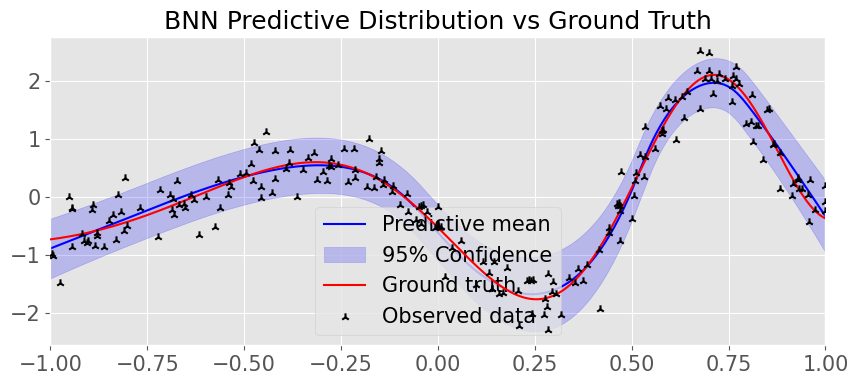

In [197]:
plot_bnn_predictive_distribution(mix_bnn_model, x_tr, y_tr)

In [198]:
## happy with the plot? capture it!
    # Compute PICP on a large test set
posterior_samples  = mix_bnn_model(x_te_dense, num_samples)[0].detach().numpy()  # Shape: (num_samples, 1000)

for alpha in alpha_values:

    lower_bounds = np.quantile(posterior_samples, alpha / 2, axis=0)
    upper_bounds = np.quantile(posterior_samples, 1 - alpha / 2, axis=0)


    # Compute coverage probabilities for gaussian noise
    coverage_probs = norm.cdf(upper_bounds, loc=true_mean, scale=noise) - \
                            norm.cdf(lower_bounds, loc=true_mean, scale=noise)
    


    # Store results
    mcp_results_mix[alpha].append(np.mean(coverage_probs))

## Get MSEs
mse_mix.append(mseloss(mix_bnn_model(x_te, num_samples)[0], y_te.unsqueeze(0)).item())


In [199]:
print(np.mean(mse_gaussian), np.mean(mse_t), np.mean(mse_lap), np.mean(mse_mix))
print(len(mse_gaussian), len(mse_t), len(mse_lap), len(mse_mix))

0.13297645524144172 0.13061951398849486 0.1321942538022995 0.13641521111130714
10 10 10 10


In [ ]:
import pickle

mses_dict_gaussian_noise = {'gaussian':mse_gaussian, 't':mse_t, 'lap':mse_lap, 'mix':mse_mix}

# Save dictionary to a pickle file
with open('mses_dict_gaussian_noise.pkl', 'wb') as f:
    pickle.dump(mses_dict_gaussian_noise, f)

# Save dictionary to a pickle file
with open('mcp_results_mix.pkl', 'wb') as f:
    pickle.dump(mcp_results_mix, f)

with open('mcp_results_gaussian.pkl', 'wb') as f:
    pickle.dump(mcp_results_gaussian, f)

with open('mcp_results_lap.pkl', 'wb') as f:
    pickle.dump(mcp_results_lap, f)

with open('mcp_results_t.pkl', 'wb') as f:
    pickle.dump(mcp_results_t, f)

In [107]:
# Print final MCP values
print("\nMCP results for Gaussian-BNN:")
for alpha in alpha_values:
    print(f"MCP (1-alpha={1-alpha:.2f}): {np.mean(mcp_results_gaussian[alpha]):.4f}")

print("\nMCP results for t-BNN:")
for alpha in alpha_values:
    print(f"MCP (1-alpha={1-alpha:.2f}): {np.mean(mcp_results_t[alpha]):.4f}")

print("\nMCP results for Laplace-BNN:")
for alpha in alpha_values:
    print(f"MCP (1-alpha={1-alpha:.2f}): {np.mean(mcp_results_lap[alpha]):.4f}")

print("\nMCP results for Mixture-BNN:")
for alpha in alpha_values:
    print(f"MCP (1-alpha={1-alpha:.2f}): {np.mean(mcp_results_mix[alpha]):.4f}")


MCP results for Gaussian-BNN:
MCP (1-alpha=0.95): 0.5443
MCP (1-alpha=0.94): 0.5270
MCP (1-alpha=0.93): 0.5106
MCP (1-alpha=0.92): 0.4963
MCP (1-alpha=0.91): 0.4832
MCP (1-alpha=0.90): 0.4703
MCP (1-alpha=0.89): 0.4584
MCP (1-alpha=0.88): 0.4470
MCP (1-alpha=0.87): 0.4371
MCP (1-alpha=0.86): 0.4276
MCP (1-alpha=0.85): 0.4181
MCP (1-alpha=0.84): 0.4090
MCP (1-alpha=0.83): 0.3999
MCP (1-alpha=0.82): 0.3911
MCP (1-alpha=0.81): 0.3828
MCP (1-alpha=0.80): 0.3742
MCP (1-alpha=0.79): 0.3658
MCP (1-alpha=0.78): 0.3576
MCP (1-alpha=0.77): 0.3503
MCP (1-alpha=0.76): 0.3435
MCP (1-alpha=0.75): 0.3369
MCP (1-alpha=0.74): 0.3303
MCP (1-alpha=0.73): 0.3236
MCP (1-alpha=0.72): 0.3170
MCP (1-alpha=0.71): 0.3109
MCP (1-alpha=0.70): 0.3051
MCP (1-alpha=0.69): 0.2991
MCP (1-alpha=0.68): 0.2930
MCP (1-alpha=0.67): 0.2875
MCP (1-alpha=0.66): 0.2822
MCP (1-alpha=0.65): 0.2770
MCP (1-alpha=0.64): 0.2719
MCP (1-alpha=0.63): 0.2669
MCP (1-alpha=0.62): 0.2619
MCP (1-alpha=0.61): 0.2570
MCP (1-alpha=0.60): 0.25